Machine learning is being used on many kinds of data, being especially successful in areas with lots of data like vision. However, we see quite little of it in meteorology, where big Numerical Weather Prediction simulations run daily that try to simulate the entire atmosphere up to weeks ahead. This takes supercomputers and lots of tweaking of the parameters to achieve good results.

Funny enough we know from [The Bitter Lesson](http://www.incompleteideas.net/IncIdeas/BitterLesson.html) that data + compute always wins. Currently we take the approach of putting more and more human knowledge (physics, approximations) into these NWP models, and by and large this is [a big success story](https://www.nature.com/articles/nature14956).

The question is, however, not if but *when* we will hit the limit where data + compute + more general ML methods will beat these amazing numerical simulations.

In this post we will do some exploratory analysis of the NOAA "Global Surface summary Of the Day" dataset, which is available as [BigQuery public dataset](https://console.cloud.google.com/marketplace/details/noaa-public/gsod).

> You can run this notebook in [Colab](https://colab.research.google.com)! Simply download [here](https://gitlab.com/The-Fonz/the-fonz.gitlab.io/raw/master/posts/1_Exploring_global_weather_data.ipynb?inline=false) and upload to Colab.

<!-- TEASER_END -->

## Basic imports

We set up plotly and gcloud libraries.

In [0]:
PROJECT = '{YOUR GCLOUD PROJECT}'

In [0]:
# We want plotly 4.0 as it has much better render support
!pip install --upgrade plotly>=4.0.0

In [0]:
from datetime import datetime

import plotly.graph_objs as go

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import Delaunay

from google.colab import auth
auth.authenticate_user()

from google.cloud.bigquery import magics

magics.context.project = PROJECT

from google.cloud import bigquery

bqc = bigquery.Client(project=PROJECT)

## 1. Retrieve and plot station position

Here we retrieve the station positions, triangulate it (for nice plotting of mesh), then plot them on a globe. We only use stations that are active during the nine years from 2010 to 2019.

In [0]:
# CONSTANTS
# Must be str
ds_begin = '20100101'
ds_end = '20190101'

In [5]:
# Use pandas directly here, could also use bigquery cell magic
df = pd.io.gbq.read_gbq(f'''
SELECT lon, lat, elev, begin, d.end
FROM `bigquery-public-data.noaa_gsod.stations` as d
WHERE begin < '{ds_begin}' AND d.end > '{ds_end}'
''', project_id=PROJECT, dialect='standard')
# Convert elevation to numeric
df.elev = pd.to_numeric(df.elev)
df.sample(3)

lon     lat  elev     begin       end
1286   15.681  58.406  52.4  19951012  20190725
3166   32.733  35.167  20.0  20090701  20190725
947   152.500 -32.183   5.0  20010915  20190724

In [6]:
pts = df[['lon', 'lat']].values

lat = np.deg2rad(df['lat'].values)
x = np.cos(np.deg2rad(df['lon'].values)) * np.cos(lat)
y = np.sin(np.deg2rad(df['lon'].values)) * np.cos(lat)
z = np.sin(lat)
xyz = np.stack((x, y, z)).T

# Do triangulation in spherical coordinates
tri = Delaunay(pts)

tri.simplices.shape

(23569, 3)

In [7]:
layout = dict(
    title = f'Weather stations active during period {ds_begin} - {ds_end}<br>(Click and drag to rotate)',
    showlegend = False,
    width=1000,
    height=1000,
    geo = dict(
        showland = True,
        showlakes = True,
        showcountries = True,
        showocean = True,
        countrywidth = 0.5,
        landcolor = 'rgb(230, 145, 56)',
        lakecolor = 'rgb(0, 255, 255)',
        oceancolor = 'rgb(0, 255, 255)',
        projection = dict( 
            type = 'orthographic',
            rotation = dict(
                lon = -100,
                lat = 40,
                roll = 0
            )            
        ),
        lonaxis = dict( 
            showgrid = True,
            gridcolor = 'rgb(102, 102, 102)',
            gridwidth = 0.5
        ),
        lataxis = dict( 
            showgrid = True,
            gridcolor = 'rgb(102, 102, 102)',
            gridwidth = 0.5
        )
    )
)
    
go.Figure(data=[
    go.Scattergeo(lon=pts[:,0], lat=pts[:,1], mode='markers')
], layout=layout)

## Station positions as graph

So we have all these points on the globe, but how can we feed this to an ML algorithm? The grid is not regular, not even on the sphere. One idea can be to encode these positions in a graph, enabling us to connect the stations to one another.

In [8]:
def plotly_trisurf(xyz, simplices, plot_edges=None):
    #x, y, z are lists of coordinates of the triangle vertices 
    #simplices are the simplices that define the triangularization;
    #simplices  is a numpy array of shape (no_triangles, 3)
    #insert here the  type check for input data

    lines = []

    for pt1, pt2, pt3 in tri.simplices:
        lines.extend([xyz[pt1].tolist(),
                      xyz[pt2].tolist(),
                      xyz[pt3].tolist(),
                      xyz[pt1].tolist(),
                      [None, None, None]
                     ])
    
    lines = np.array(lines)

    return go.Scatter3d(x=lines[:,0].tolist(),
                        y=lines[:,1].tolist(),
                        z=lines[:,2].tolist(),
                        mode='lines',
#                         line=dict(color= 'rgb(50,50,50)', width=1.5)
                       )

data1 = plotly_trisurf(xyz, tri.simplices)

layout = go.Layout(
    width=1000, height=1000,
    title=f'Weather stations plot as mesh'
)

go.Figure(data=[data1], layout=layout)

## 2. Establishing baselines

When we start training crazy triple loopback LSTM-distilled manifold-free machine learning models on this data later on, we need to know if the performance we are getting is good or not. If we predict temperature for tomorrow, is a MAE of 1.5*C good, or not?

To get a better "feel" for these numbers, we can use some (very) simple models and see how well they perform.

### Model 1: Persistence

One of the simplest models is just taking yesterday's value, which is usually surprisingly good as the weather tomorrow has high correlation with the weather today. Let's see what MAE this gives us.

In [0]:
%%bigquery df --params {"ds_begin": "20100101", "ds_end": "20190101"}
-- Select station identifier and location, and the average absolute temperature difference between two consecutive days
SELECT stn, lon, lat, elev, COUNT(*) as cnt,
    AVG(ABS(temp_c - lag_1_temp_c)) as avg_temp_diff_lag_1,
    AVG(ABS(temp_c - lag_2_temp_c)) as avg_temp_diff_lag_2,
    AVG(ABS(temp_c - lag_3_temp_c)) as avg_temp_diff_lag_3,
    AVG(ABS(temp_c - lag_7_temp_c)) as avg_temp_diff_lag_7,
    AVG(ABS(temp_c - lag_14_temp_c)) as avg_temp_diff_lag_14
FROM (
  SELECT *,
    LAG(temp_c) OVER (PARTITION BY stn ORDER BY d) as lag_1_temp_c,
    LAG(temp_c, 2) OVER (PARTITION BY stn ORDER BY d) as lag_2_temp_c,
    LAG(temp_c, 3) OVER (PARTITION BY stn ORDER BY d) as lag_3_temp_c,
    LAG(temp_c, 7) OVER (PARTITION BY stn ORDER BY d) as lag_7_temp_c,
    LAG(temp_c, 14) OVER (PARTITION BY stn ORDER BY d) as lag_14_temp_c
  FROM (
    SELECT *,
      -- From F to C
      (g.temp-32)*5/9 as temp_c,
      -- They use a funny format where year, mo and da are strings
      CAST(CONCAT(g.year, '-', g.mo, '-', g.da) as DATE) as d
    FROM `bigquery-public-data.noaa_gsod.gsod2018` as g
    LEFT JOIN `bigquery-public-data.noaa_gsod.stations` as d
    ON g.stn = d.usaf
    WHERE d.begin < @ds_begin AND d.end > @ds_end
  )
)
-- Need to group by lon/lat/elev as we want to select them, but stn alone is enough really
GROUP BY stn, lon, lat, elev
-- Order for display purposes
ORDER BY avg_temp_diff_lag_1 DESC

In [10]:
df.head()

stn     lon  ...  avg_temp_diff_lag_7 avg_temp_diff_lag_14
0  421480  79.467  ...                  NaN                  NaN
1  111420  13.183  ...                  NaN                  NaN
2  422370  72.367  ...                  NaN                  NaN
3  412161  52.464  ...                  NaN                  NaN
4  999999 -79.924  ...             8.809345             8.809345

[5 rows x 10 columns]

We immediately see that a handful of stations stand out, with Pantnagar Airport in India having extremely high day-to-day differences. Let's take a closer look and see what's up there.

In [11]:
%%bigquery
-- Select station identifier and location, and the average absolute temperature difference between two consecutive days
SELECT CAST(CONCAT(g.year, '-', g.mo, '-', g.da) as DATE) as d,
       (g.temp-32)*5/9 as temp_c
FROM `bigquery-public-data.noaa_gsod.gsod2018` as g
WHERE g.stn="421480"
ORDER BY d

d     temp_c
0  2018-08-18  32.055556
1  2018-12-11  14.222222

Aha! It has just two readings in 2018. Let's see how many readings the other stations have. I've secretly included that in the previous query, so we can graph it right away.

We exclude station "999999" as it seems to be some kind of "unknown station" code that has lots of readings. (Check `df.loc[df.cnt.idxmax()]` to find out).

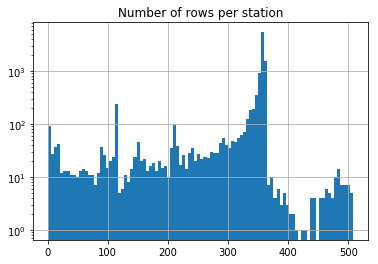

In [12]:
plt.semilogy()
plt.title("Number of rows per station")
df[df.stn!='999999'].cnt.hist(bins=100);

This is kind of strange, as we would expect most stations to have 365 readings (one per day) and some to have less, which is clearly the case, but there is also a small amount of stations that have more than 365 readings. So we just filter the stations with readings almost every day, which is the bulk of them anyway.

In [13]:
%%bigquery
SELECT COUNT(*) as n
FROM (
    SELECT stn, COUNT(*) as cnt, COUNT(DISTINCT dt) as cnt_days
    FROM (
        SELECT *, CAST(CONCAT(g.year, '-', g.mo, '-', g.da) as DATE) as dt
        FROM `bigquery-public-data.noaa_gsod.gsod2018` as g
        LEFT JOIN `bigquery-public-data.noaa_gsod.stations` as d
        ON g.stn = d.usaf
        WHERE d.begin < '20100101' AND d.end > '20190101' AND stn != '999999'
    )
    -- Need to group by lon/lat/elev as we want to select them, but stn alone is enough really
    GROUP BY stn
    HAVING cnt != cnt_days
)

n
0  147

We see that there are just 147 stations with more readings than 365, so we can safely ignore them in further analysis. At some point we can revisit this and include stations where readings are not ambiguous.

We have now basically retrieved the MAE per station over the whole year of this very simple model, and we've done it for a few different days to get more feel of how our persistence model does over the span of two weeks.

Let's graph the results.

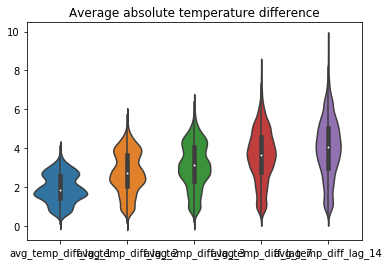

In [14]:
# Choose stations with lots of samples (this does not decrease our dataset that much)
df_subset = df[(350 < df.cnt) & (df.cnt <= 365)]
plt.title("Average absolute temperature difference")
sns.violinplot(data=df_subset[[
    "avg_temp_diff_lag_1",
    "avg_temp_diff_lag_2",
    "avg_temp_diff_lag_3",
    "avg_temp_diff_lag_7",
    "avg_temp_diff_lag_14"
]]);

We can see that for one day ahead this is approx. 2\*C on average, increasing to about 4\*C if we would forecast 14 days ahead using persistence. The lumps in the violin plot are probably due to discretization (and not at rounded numbers as we converted from F to C).

We are starting to get a "feel" for these numbers, and can now intuïtively say that a model that has MAE of 1\*C for dayahead forecast on the same subset is doing quite well compared to this "persistence" baseline model.

Let's have some more fun and find the station where the temperature tomorrow is most similar to today's, and where the temperature in 2 weeks is most similar to today's.

In [15]:
df_subset.loc[[
    df_subset.avg_temp_diff_lag_1.idxmin(),
    df_subset.avg_temp_diff_lag_14.idxmin()
]]

stn     lon  ...  avg_temp_diff_lag_7 avg_temp_diff_lag_14
10728  895780   77.02  ...             0.497942             0.949451
10709  914900 -157.35  ...             0.521051             0.541990

[2 rows x 10 columns]

The first is a [station in the antarctic](https://www.google.com/maps/search/?api=1&query=-76.42,77.02), the second [Kiribati island](https://www.google.com/maps/search/?api=1&query=1.986,-157.35) in the pacific near the equator. This again makes sense, as the antarctic probably has less weather systems and energy influx to change the temperature drastically overnight, while on an island at the equator surrounded by sea we have the more stable long-term temperature.

So now we've done some good basic analysis on this dataset, and are ready to dive in deeper. Next post will be about exporting this dataset and doing some epic ML on it.